In [2]:
import torch
import matplotlib.pyplot as plt

In [11]:
from src.utils.data_utils import CWRUDataset
from torch.utils.data import DataLoader

test_dataset = CWRUDataset('./data','test',p=1)
temp_loader = DataLoader(test_dataset, shuffle=True, batch_size=1)

test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]


In [17]:
for X,y,M in temp_loader:
    break

# 1. 진동 데이터에 노이즈 추가
***Pi-Model, Mean Teacher 등에서 랜덤 노이즈를 추가할 때 활용 가능***

*add_noise(x, snr)* : 진동 데이터(*x*)에 랜덤 노이즈를 추가해주는 함수
- SNR : 원본 신호와 노이즈의 power 비 (P_signal / P_noise)
    - SNR이 작을 수록 원본 신호 대비 노이즈가 큼

In [18]:
def add_noise(x, snr):
    '''
        [Input]
            - x : original signal
            - snr : SNR of random noise to apply
        [Output]
            - noise_data : x + noise
    '''
    snr1 = 10**(snr/10.0)
    xpower = torch.sum(x**2, dim=-1) / x.shape[-1]#len(x)
    npower = xpower/snr1
    noise = torch.randn(x.size(), device=x.device) * torch.sqrt(npower).unsqueeze(-1)
    noise_data = x+noise
    return noise_data

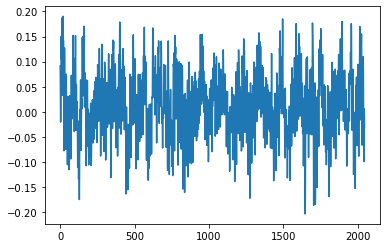

In [19]:
## Plot original data
plt.plot(X.reshape(-1))
plt.show()

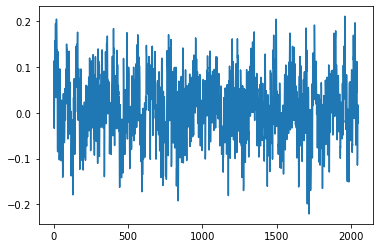

In [20]:
## Plot data applied noise, SNR=10
X_perturb = add_noise(X,10.0)
plt.plot(X_perturb.reshape(-1))
plt.show()

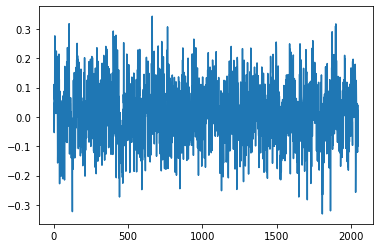

In [21]:
## Plot data applied noise, SNR=-1
X_perturb = add_noise(X,-1.0)
plt.plot(X_perturb.reshape(-1))
plt.show()

# 2. 주어진 Noise를 원하는 SNR만큼 적용하기
***VAT에서 xi / eps 등의 coefficient만큼 특정 perturbation을 주고 싶을 때 활용 가능***

*apply_snr(x, noise, snr)* : 진동 데이터(*x*)에 주어진 노이즈(*noise*)를 원하는 SNR(*snr*)만큼 적용해주는 함수
- 원본신호 *x*에 *noise*의 방향으로 *snr*에 따른 크기의 노이즈를 적용

In [25]:
def apply_snr(x, noise, snr):
    '''
        [Input]
            - x : original signal
            - noise : direction of noise
            - snr : SNR of noise to apply
        [Output]
            - noise_data : x + noise_scaled
    '''
    snr1 = 10**(snr/10.0)
    xpower = torch.sum(x**2, dim=-1, keepdim=True) / x.shape[-1]
    npower = torch.sum(noise**2, dim=-1, keepdim=True) / noise.shape[-1]
    npower_target = xpower/snr1
    noise = noise * torch.sqrt(npower_target/(npower+1e-8))
    return x+noise

In [24]:
## randomly define noise in VAT
r0 = torch.rand(X.shape).sub(0.5).to(X.device)
r0 = r0/(torch.norm(r0, dim=-1, keepdim=True)+1e-8)

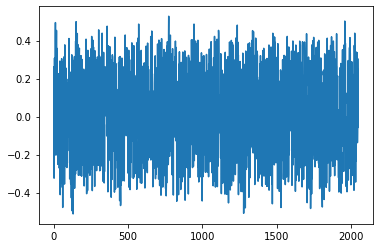

In [32]:
## Apply noise with constant scale
X_perturb = X + r0*10.0
plt.plot(X_perturb.reshape(-1))
plt.show()

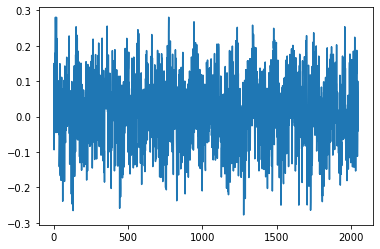

In [31]:
## Apply noise with SNR scale
X_perturb = apply_snr(X, r0, -1.0)
plt.plot(X_perturb.reshape(-1))
plt.show()